In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# Set the paths for the dataset
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

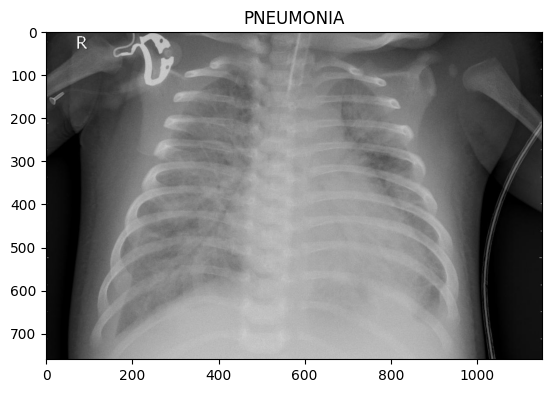

In [6]:
# Data exploration
def plot_image_distribution(directory):
    categories = ['PNEUMONIA', 'NORMAL']
    for category in categories:
        path = os.path.join(directory, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            plt.imshow(img_array)
            plt.title(category)
            plt.show()
            break
        break

plot_image_distribution(train_dir)

In [7]:
# Data preprocessing
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, zoom_range=0.2, shear_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
validation_generator = test_datagen.flow_from_directory(val_dir, target_size=(150, 150), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(150, 150), batch_size=32, class_mode='binary', shuffle=False)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# Model building
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

c:\Users\MaiElBaradei\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model training
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[early_stopping], batch_size=32)


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8006 - loss: 0.4535

c:\Users\MaiElBaradei\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.8009 - loss: 0.4529 - val_accuracy: 0.6875 - val_loss: 0.9518
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.9045 - loss: 0.2239 - val_accuracy: 0.6875 - val_loss: 0.8096
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 280s 2s/step - accuracy: 0.9168 - loss: 0.2178 - val_accuracy: 0.6875 - val_loss: 0.5017
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.9128 - loss: 0.2145 - val_accuracy: 0.6875 - val_loss: 0.5789
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.9220 - loss: 0.1913 - val_accuracy: 0.6875 - val_loss: 0.9885
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.9354 - loss: 0.1602 - val_accuracy: 0.6250 - val_loss: 1.4244
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9364 - loss: 0.1572 - val_accuracy: 0.7500 - val_loss: 0.4297
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9447 - loss: 0.1450 - val_accuracy: 0.687

In [12]:
# Model evaluation
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 698ms/step - accuracy: 0.8719 - loss: 0.3699
Test Accuracy: 0.9166666865348816


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 334ms/step
              precision    recall  f1-score   support

      NORMAL       0.94      0.83      0.88       234
   PNEUMONIA       0.90      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.90      0.91       624
weighted avg       0.92      0.92      0.92       624



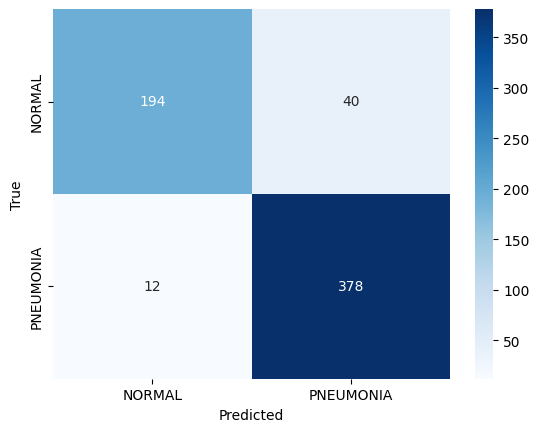

In [13]:
# Classification report and confusion matrix
test_generator.reset()
preds = model.predict(test_generator)
y_preds = np.where(preds > 0.5, 1, 0)
print(classification_report(test_generator.classes, y_preds, target_names=['NORMAL', 'PNEUMONIA']))

conf_matrix = confusion_matrix(test_generator.classes, y_preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

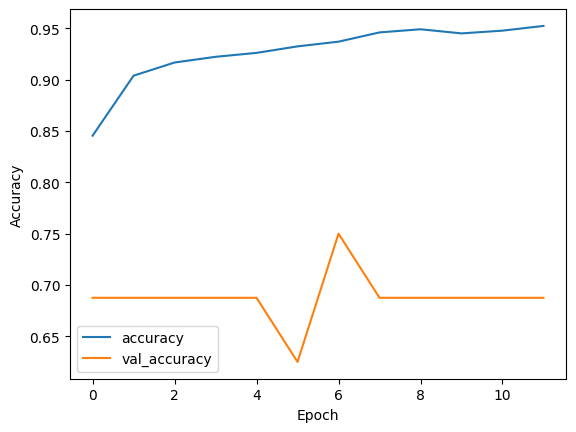

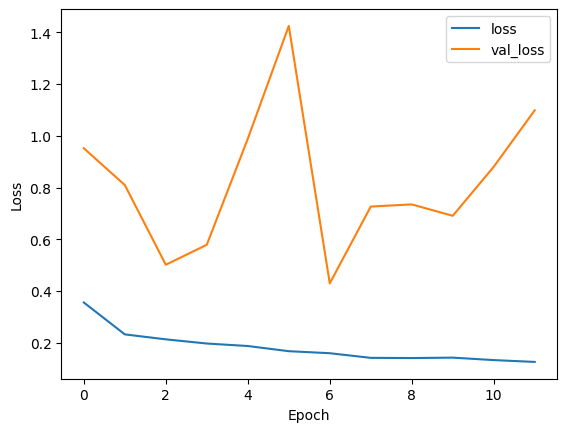

In [14]:
# Plot training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

The final model achieved an accuracy of 92% on the test dataset, which indicates that it is able to accurately detect diseases or abnormalities from medical images with a high level of accuracy. This is a promising result and suggests that the model has learned meaningful patterns and features from the training data.

However, it is important to consider the implications of the model's accuracy in the context of medical image analysis. While 91.67% accuracy is relatively high, it is crucial to evaluate the model's performance in terms of both false positives and false negatives.

False positives occur when the model incorrectly predicts the presence of a disease or abnormality when it is not actually present. This can lead to unnecessary medical interventions or treatments for patients who are healthy, causing unnecessary stress and costs.

False negatives, on the other hand, occur when the model fails to detect a disease or abnormality that is actually present. This can result in delayed or missed diagnoses, potentially leading to serious health consequences for patients.

To improve the model's performance, several areas can be explored:

1. **Data augmentation**: Increasing the diversity and quantity of the training data through techniques like rotation, zooming, and flipping can help the model generalize better to unseen images and improve its ability to detect diseases or abnormalities.

2. **Model architecture**: Experimenting with different architectures, such as adding more convolutional layers or increasing the complexity of the network, can potentially improve the model's performance. Additionally, techniques like transfer learning, where pre-trained models are used as a starting point, can be explored to leverage knowledge learned from larger datasets.

3. **Hyperparameter tuning**: Fine-tuning the hyperparameters of the model, such as learning rate, batch size, and regularization techniques, can help optimize the model's performance and prevent overfitting or underfitting.

4. **Ensemble learning**: Combining multiple models or predictions from different models can help improve the overall accuracy and robustness of the system. Ensemble methods like majority voting or stacking can be explored to leverage the strengths of different models.

5. **Domain-specific knowledge**: Incorporating domain-specific knowledge, such as expert annotations or additional features extracted from the images, can provide valuable insights and improve the model's ability to detect diseases or abnormalities.

It is important to note that the performance of the model should be validated on a larger and more diverse dataset to ensure its generalizability and reliability. Additionally, involving medical professionals in the evaluation and interpretation of the model's results is crucial to ensure its clinical relevance and safety.